# 🏆 Prédictions Ligue 1 - Méthode du Classement

Ce notebook utilise une méthode de prédiction basée sur **la position au classement**, avec des probabilités calculées comme **l'inverse du rang**.

## ⚠️ Prérequis Important

**Avant d'utiliser ce notebook**, vous devez d'abord exécuter :

### 📥 `0_collecte_donnees.ipynb`

Ce notebook collecte et met en cache le classement de la Ligue 1.

**Sans cette étape**, ce notebook ne pourra pas fonctionner car il utilise **uniquement les données du cache** (aucun appel API direct).

---

## 🎯 Méthodologie

### Calcul des Probabilités

Pour un match entre l'équipe A (rang $r_A$) et l'équipe B (rang $r_B$) :

$$\text{Score}_A = \frac{1}{r_A}, \quad \text{Score}_B = \frac{1}{r_B}$$

$$\text{Total} = \text{Score}_A + \text{Score}_B$$

$$P(\text{Victoire A}) = \frac{\text{Score}_A}{\text{Total}}, \quad P(\text{Victoire B}) = \frac{\text{Score}_B}{\text{Total}}$$

### Exemple

Match entre le 1er et le 5ème du classement :
- Score du 1er = $\frac{1}{1} = 1.000$
- Score du 5ème = $\frac{1}{5} = 0.200$
- Total = $1.200$
- Probabilité victoire 1er = $\frac{1.000}{1.200} \approx 83.3\%$
- Probabilité victoire 5ème = $\frac{0.200}{1.200} \approx 16.7\%$

### Caractéristiques

✅ **Simple** : Basé uniquement sur le classement  
✅ **Intuitif** : Le favori est toujours celui qui est mieux classé  
✅ **Probabiliste** : Les résultats sont exprimés en probabilités qui somment à 100%  
✅ **Sans API** : Pas d'appels API dans ce notebook  
❌ **Limites** : Ne prend pas en compte la forme récente, domicile/extérieur, ou les blessures

## 📋 Prérequis

1. Obtenir une clé API gratuite sur [API-Football](https://www.api-football.com/) (100 requêtes/jour)
2. Installer les dépendances nécessaires
3. Exécuter `0_collecte_donnees.ipynb` pour mettre en cache les données

In [1]:
# Installation des dépendances (à exécuter une seule fois)
# !pip install requests pandas numpy python-dotenv

import requests
import json
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
import time
import hashlib

print("✅ Bibliothèques importées")

✅ Bibliothèques importées


In [2]:
# Configuration - Chargement depuis .env
load_dotenv()

API_KEY = os.getenv("API_FOOTBALL_KEY", "votre_clé_api_ici")
LIGUE1_ID = int(os.getenv("LIGUE1_ID", 61))
CURRENT_SEASON = int(os.getenv("CURRENT_SEASON", 2025))

print(f"✅ Configuration chargée : Ligue {LIGUE1_ID}, Saison {CURRENT_SEASON}")
print(f"📅 Saison {CURRENT_SEASON}-{CURRENT_SEASON+1}")

if API_KEY == "votre_clé_api_ici":
    print("⚠️ N'oubliez pas de configurer votre API_FOOTBALL_KEY dans le fichier .env")

✅ Configuration chargée : Ligue 61, Saison 2025
📅 Saison 2025-2026


## 🔧 Classe FootballAPI

Classe pour récupérer les données depuis le cache (pas d'appels API directs dans ce notebook).

In [3]:
class FootballAPI:
    """Classe pour interagir avec l'API-Football avec système de cache sur disque"""
    
    def __init__(self, api_key, league_id=61, season=2025, cache_duration=3600, cache_dir='cache'):
        self.base_url = "https://v3.football.api-sports.io"
        self.headers = {'x-apisports-key': api_key}
        self.league_id = league_id
        self.season = season
        self.cache_duration = cache_duration
        self.cache_dir = cache_dir
        self.api_calls = 0
        
        if not os.path.exists(self.cache_dir):
            os.makedirs(self.cache_dir)
            print(f"📁 Dossier cache créé: {self.cache_dir}")
    
    def _get_cache_key(self, endpoint, params):
        params_str = '&'.join([f"{k}={v}" for k, v in sorted(params.items())])
        return f"{endpoint}?{params_str}"
    
    def _get_cache_filename(self, cache_key):
        hash_key = hashlib.md5(cache_key.encode()).hexdigest()
        return os.path.join(self.cache_dir, f"{hash_key}.json")
    
    def _get_from_cache(self, cache_key):
        cache_file = self._get_cache_filename(cache_key)
        
        if os.path.exists(cache_file):
            file_age = time.time() - os.path.getmtime(cache_file)
            
            if file_age < self.cache_duration:
                with open(cache_file, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                print(f"💾 Données récupérées du cache (âge: {int(file_age/60)} min)")
                return data
        
        return None
    
    def _save_to_cache(self, cache_key, data):
        cache_file = self._get_cache_filename(cache_key)
        with open(cache_file, 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=2)
    
    def _make_request(self, endpoint, params=None):
        if params is None:
            params = {}
        
        cache_key = self._get_cache_key(endpoint, params)
        cached_data = self._get_from_cache(cache_key)
        
        if cached_data is not None:
            return cached_data
        
        url = f"{self.base_url}/{endpoint}"
        response = requests.get(url, headers=self.headers, params=params)
        self.api_calls += 1
        
        if response.status_code == 200:
            data = response.json()
            self._save_to_cache(cache_key, data)
            print(f"🌐 Données récupérées de l'API (appel #{self.api_calls})")
            return data
        else:
            print(f"❌ Erreur API: {response.status_code}")
            return None
    
    def get_standings(self):
        """Récupère le classement de la ligue"""
        params = {'league': self.league_id, 'season': self.season}
        return self._make_request('standings', params)

print("✅ Classe FootballAPI chargée")

✅ Classe FootballAPI chargée


## 📊 Récupération du Classement

On récupère le classement depuis le cache (rempli par `0_collecte_donnees.ipynb`).

In [4]:
# Initialisation de l'API
api = FootballAPI(API_KEY, league_id=LIGUE1_ID, season=CURRENT_SEASON)

# Récupération du classement
standings_data = api.get_standings()

if standings_data and 'response' in standings_data and len(standings_data['response']) > 0:
    teams = standings_data['response'][0]['league']['standings'][0]
    print(f"✅ {len(teams)} équipes récupérées du classement")
else:
    print("❌ Impossible de récupérer le classement")
    print("⚠️ Assurez-vous d'avoir exécuté 0_collecte_donnees.ipynb d'abord!")

🌐 Données récupérées de l'API (appel #1)
✅ 18 équipes récupérées du classement


In [5]:
# Création d'un DataFrame avec les données de classement
standings_list = []

for team in teams:
    standings_list.append({
        'rang': team['rank'],
        'equipe': team['team']['name'],
        'equipe_id': team['team']['id'],
        'points': team['points'],
        'joues': team['all']['played'],
        'victoires': team['all']['win'],
        'nuls': team['all']['draw'],
        'defaites': team['all']['lose'],
        'buts_pour': team['all']['goals']['for'],
        'buts_contre': team['all']['goals']['against'],
        'diff': team['goalsDiff']
    })

df_standings = pd.DataFrame(standings_list)

print("\n🏆 Classement de la Ligue 1\n")
print(df_standings.to_string(index=False))


🏆 Classement de la Ligue 1

 rang              equipe  equipe_id  points  joues  victoires  nuls  defaites  buts_pour  buts_contre  diff
    1                Lens        116      49     21         16     1         4         37           17    20
    2 Paris Saint Germain         85      48     20         15     3         2         43           16    27
    3                Lyon         80      42     21         13     3         5         34           20    14
    4           Marseille         81      39     20         12     3         5         46           22    24
    5               Lille         79      33     21         10     3         8         34           30     4
    6          Strasbourg         95      31     21          9     4         8         34           26     8
    7            Toulouse         96      31     21          8     7         6         31           23     8
    8              Rennes         94      31     21          8     7         6         31          

## 🎯 Fonction de Prédiction basée sur le Classement

Implémentation de la méthode de l'inverse du rang.

In [6]:
def predict_match_by_ranking(team1_name, team2_name, df_standings):
    """
    Prédit un match basé sur la position au classement.
    La probabilité est proportionnelle à l'inverse du rang.
    
    Args:
        team1_name: Nom de la première équipe
        team2_name: Nom de la deuxième équipe
        df_standings: DataFrame avec le classement
    
    Returns:
        dict: Dictionnaire avec les prédictions et probabilités
    """
    # Recherche des équipes dans le classement
    team1_data = df_standings[df_standings['equipe'].str.contains(team1_name, case=False, na=False)]
    team2_data = df_standings[df_standings['equipe'].str.contains(team2_name, case=False, na=False)]
    
    if team1_data.empty:
        return {"erreur": f"Équipe '{team1_name}' non trouvée dans le classement"}
    if team2_data.empty:
        return {"erreur": f"Équipe '{team2_name}' non trouvée dans le classement"}
    
    team1 = team1_data.iloc[0]
    team2 = team2_data.iloc[0]
    
    # Récupération des rangs
    rank1 = team1['rang']
    rank2 = team2['rang']
    
    # Calcul des scores (inverse du rang)
    score1 = 1.0 / rank1
    score2 = 1.0 / rank2
    
    # Normalisation pour obtenir des probabilités
    total = score1 + score2
    prob1 = score1 / total
    prob2 = score2 / total
    
    # Détermination du favori
    if prob1 > prob2:
        prediction = team1['equipe']
        confiance = prob1
    else:
        prediction = team2['equipe']
        confiance = prob2
    
    return {
        'equipe1': team1['equipe'],
        'rang1': rank1,
        'score1': score1,
        'probabilite1': prob1,
        'equipe2': team2['equipe'],
        'rang2': rank2,
        'score2': score2,
        'probabilite2': prob2,
        'prediction': prediction,
        'confiance': confiance,
        'ecart_rangs': abs(rank1 - rank2)
    }

print("✅ Fonction de prédiction chargée")

✅ Fonction de prédiction chargée


In [7]:
def display_prediction_ranking(result):
    """
    Affiche une prédiction de manière formatée.
    """
    if 'erreur' in result:
        print(f"❌ {result['erreur']}")
        return
    
    print("\n" + "="*80)
    print(f"🏆 PRÉDICTION : {result['equipe1']} 🆚 {result['equipe2']}")
    print("="*80)
    
    print(f"\n📊 Données du Classement:")
    print(f"   {result['equipe1']}: {result['rang1']}ème position")
    print(f"   {result['equipe2']}: {result['rang2']}ème position")
    print(f"   Écart de rangs: {result['ecart_rangs']} positions")
    
    print(f"\n🎯 Scores (inverse du rang):")
    print(f"   {result['equipe1']}: {result['score1']:.4f}")
    print(f"   {result['equipe2']}: {result['score2']:.4f}")
    
    print(f"\n📈 Probabilités de victoire:")
    print(f"   {result['equipe1']}: {result['probabilite1']*100:.1f}%")
    print(f"   {result['equipe2']}: {result['probabilite2']*100:.1f}%")
    
    # Barre de probabilité visuelle
    bar_length = 50
    bar1_length = int(result['probabilite1'] * bar_length)
    bar2_length = bar_length - bar1_length
    
    print(f"\n   [{('█' * bar1_length)}{('░' * bar2_length)}]")
    
    print(f"\n🎯 PRÉDICTION FINALE:")
    print(f"   Vainqueur probable: {result['prediction']}")
    print(f"   Confiance: {result['confiance']*100:.1f}%")
    
    # Interprétation
    if result['confiance'] > 0.75:
        interpretation = "Victoire très probable (grand écart au classement)"
    elif result['confiance'] > 0.65:
        interpretation = "Victoire probable (écart significatif)"
    elif result['confiance'] > 0.55:
        interpretation = "Léger avantage (classement proche)"
    else:
        interpretation = "Match très serré (classement similaire)"
    
    print(f"   Interprétation: {interpretation}")
    print("="*80 + "\n")

print("✅ Fonction d'affichage chargée")

✅ Fonction d'affichage chargée


## 🧪 Exemples de Prédictions

Testons la méthode avec quelques matchs.

In [15]:
# Exemple 1: Match entre le leader et une équipe du milieu de tableau
result = predict_match_by_ranking("Paris Saint Germain", "Marseille", df_standings)
display_prediction_ranking(result)


🏆 PRÉDICTION : Paris Saint Germain 🆚 Marseille

📊 Données du Classement:
   Paris Saint Germain: 2ème position
   Marseille: 4ème position
   Écart de rangs: 2 positions

🎯 Scores (inverse du rang):
   Paris Saint Germain: 0.5000
   Marseille: 0.2500

📈 Probabilités de victoire:
   Paris Saint Germain: 66.7%
   Marseille: 33.3%

   [█████████████████████████████████░░░░░░░░░░░░░░░░░]

🎯 PRÉDICTION FINALE:
   Vainqueur probable: Paris Saint Germain
   Confiance: 66.7%
   Interprétation: Victoire probable (écart significatif)



In [9]:
# Exemple 2: Match serré entre deux équipes proches au classement
result = predict_match_by_ranking("Lyon", "Monaco", df_standings)
display_prediction_ranking(result)


🏆 PRÉDICTION : Lyon 🆚 Monaco

📊 Données du Classement:
   Lyon: 3ème position
   Monaco: 9ème position
   Écart de rangs: 6 positions

🎯 Scores (inverse du rang):
   Lyon: 0.3333
   Monaco: 0.1111

📈 Probabilités de victoire:
   Lyon: 75.0%
   Monaco: 25.0%

   [█████████████████████████████████████░░░░░░░░░░░░░]

🎯 PRÉDICTION FINALE:
   Vainqueur probable: Lyon
   Confiance: 75.0%
   Interprétation: Victoire probable (écart significatif)



In [16]:
# Exemple 3: Match entre une équipe de haut de tableau et une équipe en difficulté
result = predict_match_by_ranking("Lille", "Metz", df_standings)
display_prediction_ranking(result)


🏆 PRÉDICTION : Lille 🆚 Metz

📊 Données du Classement:
   Lille: 5ème position
   Metz: 18ème position
   Écart de rangs: 13 positions

🎯 Scores (inverse du rang):
   Lille: 0.2000
   Metz: 0.0556

📈 Probabilités de victoire:
   Lille: 78.3%
   Metz: 21.7%

   [███████████████████████████████████████░░░░░░░░░░░]

🎯 PRÉDICTION FINALE:
   Vainqueur probable: Lille
   Confiance: 78.3%
   Interprétation: Victoire très probable (grand écart au classement)



## 📊 Analyse Comparative des Probabilités

Visualisons comment les probabilités varient selon l'écart de classement.

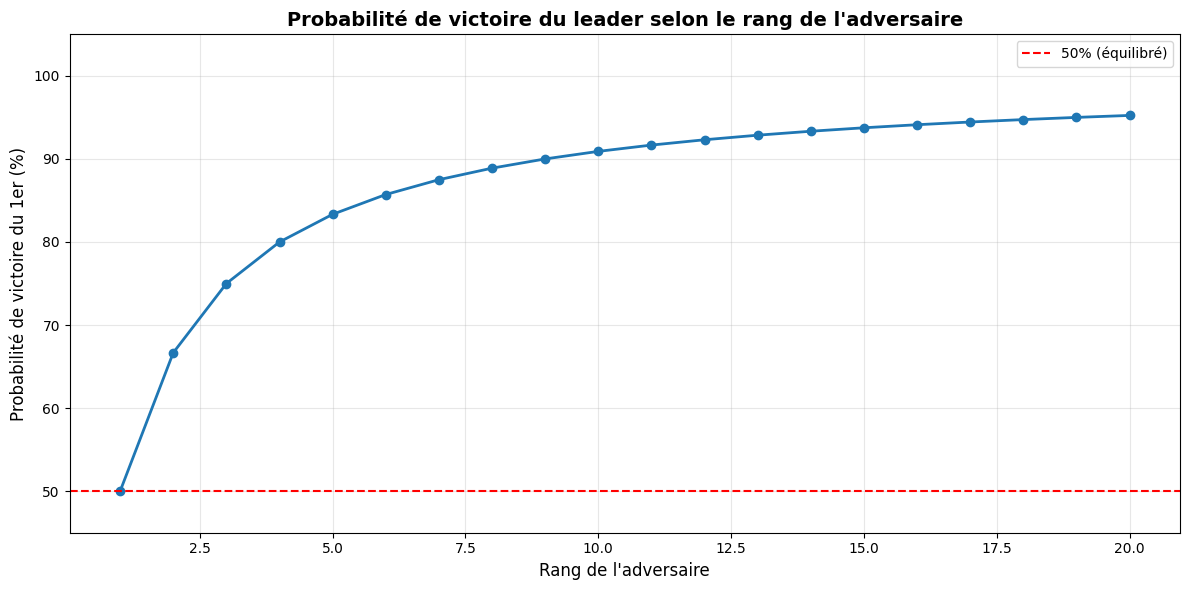

📊 Graphique généré


In [11]:
# Simulation de probabilités pour différents écarts de rang
import matplotlib.pyplot as plt

# Équipe de référence: 1ère place
rank_ref = 1
ranks_opponent = range(1, 21)
probabilities = []

for rank_opp in ranks_opponent:
    score_ref = 1.0 / rank_ref
    score_opp = 1.0 / rank_opp
    total = score_ref + score_opp
    prob_ref = score_ref / total
    probabilities.append(prob_ref * 100)

plt.figure(figsize=(12, 6))
plt.plot(ranks_opponent, probabilities, marker='o', linewidth=2, markersize=6)
plt.axhline(y=50, color='r', linestyle='--', label='50% (équilibré)')
plt.xlabel('Rang de l\'adversaire', fontsize=12)
plt.ylabel('Probabilité de victoire du 1er (%)', fontsize=12)
plt.title('Probabilité de victoire du leader selon le rang de l\'adversaire', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.ylim(45, 105)
plt.tight_layout()
plt.show()

print("📊 Graphique généré")

## 🎲 Fonction Interactive

Prédisez un match en saisissant les noms des équipes.

In [12]:
def predict_custom_match():
    """
    Fonction interactive pour prédire un match personnalisé.
    """
    print("\n🏆 PRÉDICTION PERSONNALISÉE - MÉTHODE DU CLASSEMENT\n")
    print("Équipes disponibles:")
    print(df_standings[['rang', 'equipe', 'points']].to_string(index=False))
    print("\n" + "="*80 + "\n")
    
    team1 = input("Équipe 1 (nom partiel suffit): ")
    team2 = input("Équipe 2 (nom partiel suffit): ")
    
    result = predict_match_by_ranking(team1, team2, df_standings)
    display_prediction_ranking(result)

# Décommentez la ligne suivante pour une prédiction interactive
# predict_custom_match()

## 📈 Analyse Complète: Tous les Matchs Possibles

Calculons les probabilités pour tous les matchs possibles entre les 10 premières équipes.

In [13]:
# Top 10 des équipes
top_teams = df_standings.head(10)

# Matrice de probabilités
n_teams = len(top_teams)
prob_matrix = np.zeros((n_teams, n_teams))

for i, team1 in top_teams.iterrows():
    for j, team2 in top_teams.iterrows():
        if i != j:
            score1 = 1.0 / team1['rang']
            score2 = 1.0 / team2['rang']
            total = score1 + score2
            prob1 = score1 / total
            prob_matrix[i, j] = prob1 * 100

# Affichage de la matrice
df_prob_matrix = pd.DataFrame(
    prob_matrix,
    index=top_teams['equipe'].values,
    columns=top_teams['equipe'].values
)

print("\n📊 Matrice des Probabilités de Victoire (%) - Top 10")
print("Ligne = Équipe à domicile | Colonne = Équipe à l'extérieur\n")
print(df_prob_matrix.round(1).to_string())
print("\n💡 Les valeurs représentent la probabilité de victoire de l'équipe en ligne")


📊 Matrice des Probabilités de Victoire (%) - Top 10
Ligne = Équipe à domicile | Colonne = Équipe à l'extérieur

                     Lens  Paris Saint Germain  Lyon  Marseille  Lille  Strasbourg  Toulouse  Rennes  Monaco  Lorient
Lens                  0.0                 66.7  75.0       80.0   83.3        85.7      87.5    88.9    90.0     90.9
Paris Saint Germain  33.3                  0.0  60.0       66.7   71.4        75.0      77.8    80.0    81.8     83.3
Lyon                 25.0                 40.0   0.0       57.1   62.5        66.7      70.0    72.7    75.0     76.9
Marseille            20.0                 33.3  42.9        0.0   55.6        60.0      63.6    66.7    69.2     71.4
Lille                16.7                 28.6  37.5       44.4    0.0        54.5      58.3    61.5    64.3     66.7
Strasbourg           14.3                 25.0  33.3       40.0   45.5         0.0      53.8    57.1    60.0     62.5
Toulouse             12.5                 22.2  30.0       36

## 📊 Visualisation: Heatmap des Probabilités

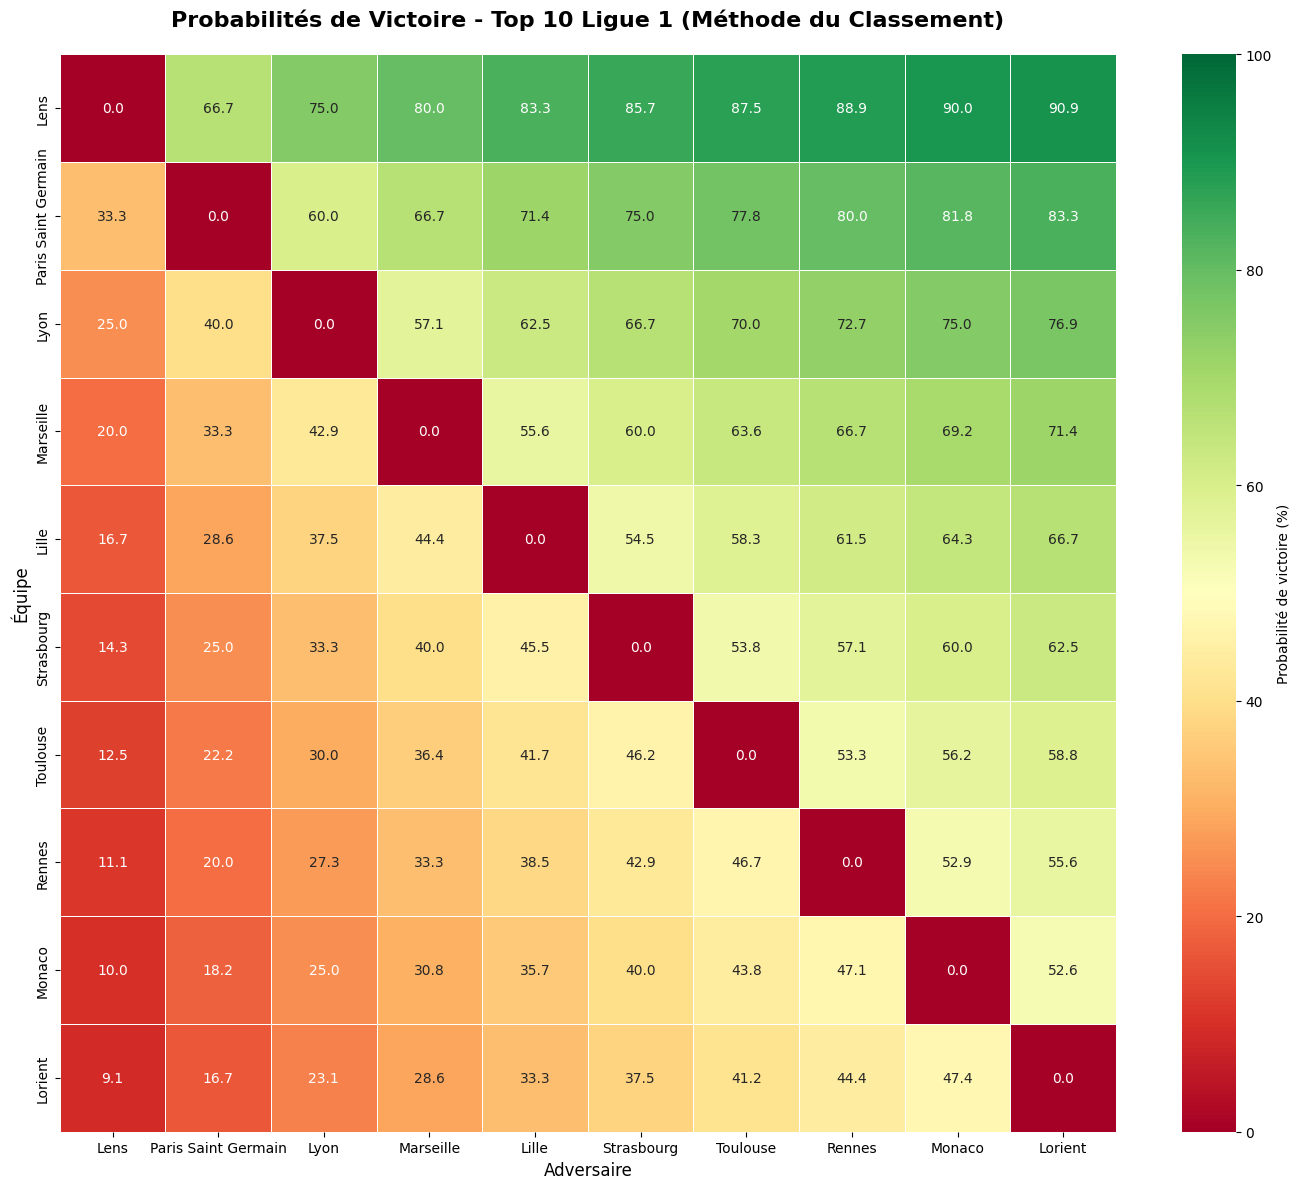

✅ Heatmap générée


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 12))
sns.heatmap(
    df_prob_matrix,
    annot=True,
    fmt='.1f',
    cmap='RdYlGn',
    center=50,
    vmin=0,
    vmax=100,
    cbar_kws={'label': 'Probabilité de victoire (%)'},
    linewidths=0.5
)
plt.title('Probabilités de Victoire - Top 10 Ligue 1 (Méthode du Classement)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Adversaire', fontsize=12)
plt.ylabel('Équipe', fontsize=12)
plt.tight_layout()
plt.show()

print("✅ Heatmap générée")

## 📝 Résumé et Limites

### ✅ Avantages

1. **Simplicité**: Calcul basé uniquement sur le rang au classement
2. **Transparence**: Formule mathématique claire et compréhensible
3. **Probabilités**: Résultats exprimés en probabilités normalisées
4. **Rapidité**: Aucun calcul complexe nécessaire

### ❌ Limites

1. **Forme récente ignorée**: Ne prend pas en compte les résultats récents
2. **Contexte du match**: Ignore domicile/extérieur, météo, motivation
3. **Blessures**: Ne considère pas les joueurs absents
4. **Écarts de points**: Deux équipes à 2 rangs d'écart peuvent avoir 1 ou 10 points d'écart
5. **Surprise**: Cette méthode favorise toujours le mieux classé

### 💡 Recommandations

- Utiliser cette méthode comme **base de référence**
- Combiner avec d'autres méthodes pour plus de précision
- Ne pas l'utiliser seule pour des paris importants
- Vérifier la forme récente manuellement

### 🔗 Notebooks Complémentaires

- `1_predictions_simples.ipynb`: Prédictions basées sur la forme et les buts
- `2_predictions_stats_avancees.ipynb`: Avec xG et statistiques avancées
- `3_predictions_ml.ipynb`: Machine Learning pour des prédictions plus sophistiquées